In [151]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import copy

定义Gram Matrix

In [152]:
class GramMatrix(nn.Module):
    def forward(self, input):
        """
        b for batch size, n for number of feature maps,
        h, w for height, width
        """
        b, n, h, w = input.size()
        features = input.view(b * n, h * w)
        gm = torch.mm(features, features.t())
        return gm.div(b * n * h * w)

定义内容损失

In [153]:
class ContentLoss(nn.Module):
    def __init__(self, weight, target):
        super(ContentLoss, self).__init__()
        self.weight = weight
        self.target = target.detach() * weight
        self.loss_fn = nn.MSELoss()

    def forward(self, input):
        self.loss = self.loss_fn(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self):
        self.loss.backward(retain_graph=True)
        return self.loss

定义风格损失

In [154]:
class StyleLoss(nn.Module):
    def __init__(self, weight, target):
        super(StyleLoss, self).__init__()
        self.weight = weight
        self.target = target.detach() * weight
        self.loss_fn = nn.MSELoss()
        self.gram = GramMatrix()

    def forward(self, input):
        self.output = input.clone()
        self.GM = self.gram(input)
        self.GM.mul_(self.weight)
        self.loss = self.loss_fn(self.GM, self.target)
        return self.output

    def backward(self):
        self.loss.backward(retain_graph=True)
        return self.loss

加载、展示图片

In [155]:
def load_img(path):
    transformer = transforms.Compose([transforms.Resize([256, 256]),
                                     transforms.ToTensor()])
    img = Image.open(path)
    img = transformer(img)
    img = img.unsqueeze(0)
    return img

In [156]:
content_img = load_img("./content.jpg")
style_img = load_img("./style.jpg")
content_img = Variable(content_img)
style_img = Variable(style_img)
if torch.cuda.is_available():
    content_img = content_img.cuda()
    style_img = style_img.cuda()

In [157]:
def show_img(img, title=None):
    unloader = transforms.ToPILImage()
    img = img.clone().cpu()
    img = img.squeeze(0)
    img = unloader(img)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

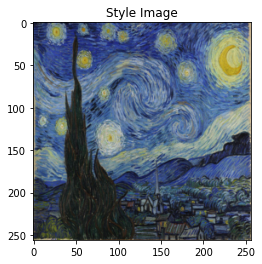

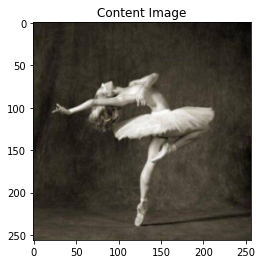

In [158]:
plt.figure()
show_img(style_img, title='Style Image')
show_img(content_img, title='Content Image')

加载预训练的VGG19模型

In [159]:
vgg = models.vgg19(pretrained=True).features
my_model = nn.Sequential()
if torch.cuda.is_available():
    vgg = vgg.cuda()
    my_model = my_model.cuda()
model = copy.deepcopy(vgg)

c:\Users\dekrt\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\dekrt\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [160]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

传入自定义的损失函数

In [161]:
content_layers = ["Conv_4"]
style_layers = ["Conv_1", "Conv_2", "Conv_3", "Conv_4", "Conv_5"]
content_losses = []
style_losses = []
content_weight = 1
style_weight = 1000
gram = GramMatrix()
i = 1  # index

if torch.cuda.is_available():
    gram = gram.cuda()
    my_model = my_model.cuda()

for layer in list(model):

    if isinstance(layer, nn.Conv2d):
        name = 'Conv_' + str(i)
        my_model.add_module(name, layer)
        if name in content_layers:
            target = my_model(content_img).clone()
            content_loss = ContentLoss(content_weight, target)
            my_model.add_module("content_loss_"+str(i), content_loss)
            content_losses.append(content_loss)
        if name in style_layers:
            target = my_model(style_img).clone()
            target = gram(target)
            style_loss = StyleLoss(style_weight, target)
            my_model.add_module("style_loss_"+str(i), style_loss)
            style_losses.append(style_loss)
    
    if isinstance(layer, nn.ReLU):
        name = "Relu_"+str(i)
        my_model.add_module(name, layer)
        i += 1
            
    if isinstance(layer, nn.MaxPool2d):
        name = "MaxPool_"+str(i)
        my_model.add_module(name, layer)
print(my_model)

Sequential(
  (Conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss(
    (loss_fn): MSELoss()
    (gram): GramMatrix()
  )
  (Relu_1): ReLU(inplace=True)
  (Conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss(
    (loss_fn): MSELoss()
    (gram): GramMatrix()
  )
  (Relu_2): ReLU(inplace=True)
  (MaxPool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss(
    (loss_fn): MSELoss()
    (gram): GramMatrix()
  )
  (Relu_3): ReLU(inplace=True)
  (Conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss(
    (loss_fn): MSELoss()
  )
  (style_loss_4): StyleLoss(
    (loss_fn): MSELoss()
    (gram): GramMatrix()
  )
  (Relu_4): ReLU(inplace=True)
  (MaxPool_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [162]:
input_img = content_img.clone()

parameter = nn.Parameter(input_img.data)
optimizer = torch.optim.LBFGS([parameter])

进行训练

Run 50: Style Loss : 1.793692 Content Loss: 2.174976


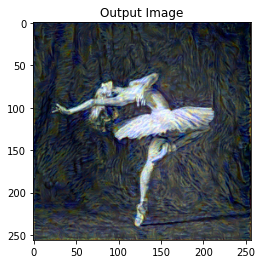

Run 100: Style Loss : 0.542354 Content Loss: 1.933578


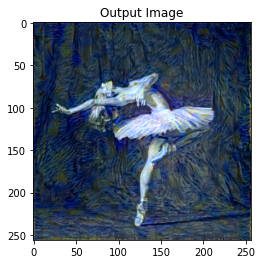

Run 150: Style Loss : 0.367741 Content Loss: 1.837000


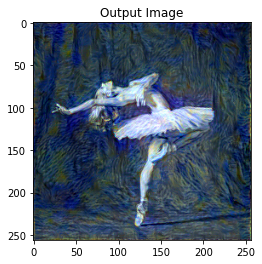

Run 200: Style Loss : 0.198976 Content Loss: 1.807828


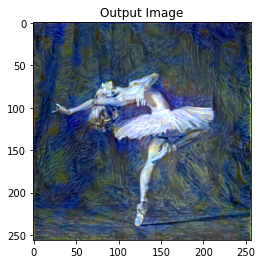

Run 250: Style Loss : 0.135088 Content Loss: 1.776774


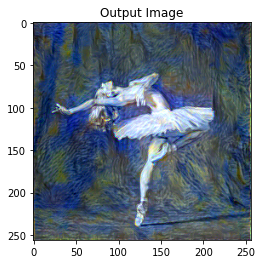

Run 300: Style Loss : 0.126436 Content Loss: 1.752911


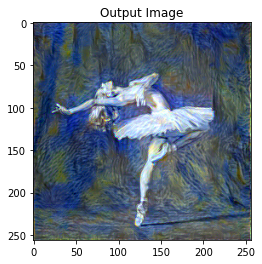

Run 350: Style Loss : 0.124216 Content Loss: 1.738680


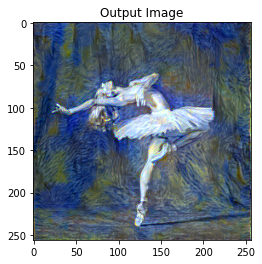

Run 400: Style Loss : 0.121345 Content Loss: 1.730020


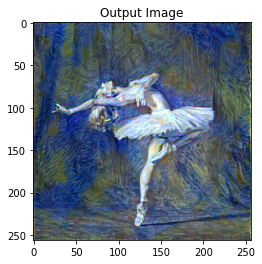

Run 450: Style Loss : 0.120147 Content Loss: 1.722361


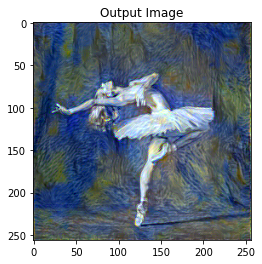

Run 500: Style Loss : 0.118789 Content Loss: 1.719348


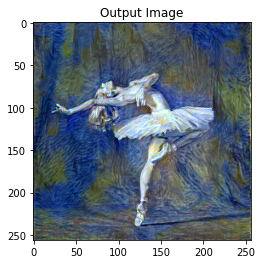

In [163]:
epoch = 500
run = [0]
x_label = []
style_scores = []
content_scores = []
while run[0] <= epoch:
    def closure():
        optimizer.zero_grad()
        style_score = 0
        content_score = 0
        parameter.data.clamp_(0, 1)
        my_model(parameter)
        
        for sl in style_losses:
            style_score += sl.backward()
        
        for cl in content_losses:
            content_score += cl.backward()
        
        run[0] += 1 
        if run[0] % 50 == 0:
            print('Run {}: Style Loss : {:4f} Content Loss: {:4f}'.format(
                run[0], style_score.item(), content_score.item()))
            x_label.append(run[0])
            style_scores.append(style_score.item())
            content_scores.append(content_score.item())
            parameter.data.clamp_(0, 1)
            plt.figure()
            show_img(parameter.data, title="Output Image")

        return style_score + content_score
    optimizer.step(closure)

<Figure size 432x288 with 0 Axes>

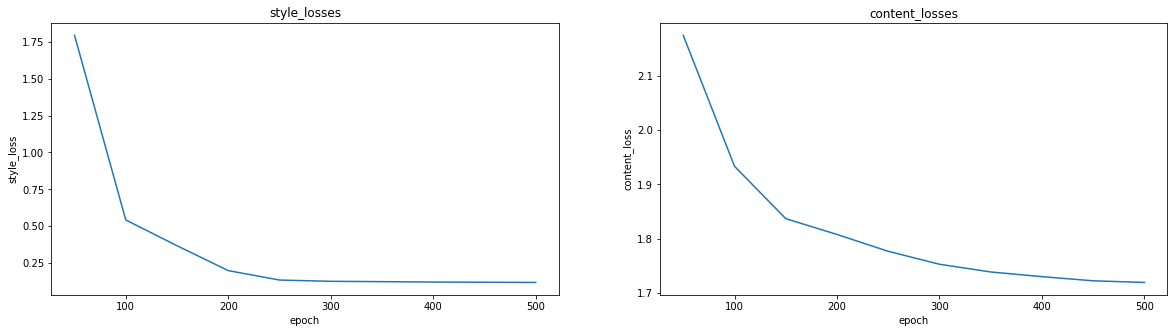

In [164]:
plt.figure()
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].plot(x_label, style_scores)
axes[1].plot(x_label, content_scores)
axes[0].set_xlabel("epoch")
axes[1].set_xlabel("epoch")
axes[0].set_ylabel("style_loss")
axes[1].set_ylabel("content_loss")
axes[0].set_title("style_losses")
axes[1].set_title("content_losses")
plt.show()

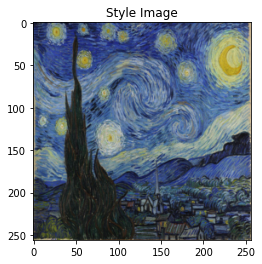

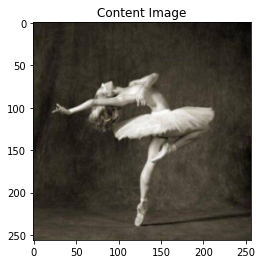

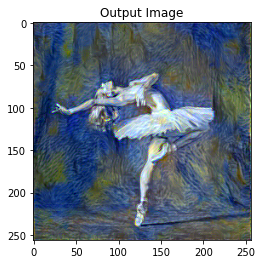

In [166]:
parameter.data.clamp_(0, 1)
show_img(style_img, title='Style Image')
show_img(content_img, title='Content Image')
show_img(parameter.data, title="Output Image")